<a href="https://colab.research.google.com/github/erni26/pemograman_python/blob/main/Adam_lr0_0001_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/uji-ls;0.0001

/content/drive/MyDrive/uji-ls;0.0001


In [ ]:
pwd

'/content/drive/MyDrive/uji-ls;0.0001'

In [ ]:
from PIL import Image
import numpy as np
import os
from imutils import paths

In [ ]:
image_paths=paths.list_images("DatasetF")
gambar = []
label = []

In [ ]:
for images in image_paths:
  image = Image.open(images)
  image = np.array(image.resize((128,128))) / 255.0

  gambar.append(image)
  labels=images.split(os.path.sep)[-2]
  label.append(labels)

In [ ]:
temp = np.array(gambar)
temp = np.expand_dims(temp, axis=3)
print(temp.shape)

(1624, 128, 128, 1, 3)


In [ ]:
#untuk rgb
temp = np.array(gambar)
print(temp.shape)
temp2=np.array(label)
print(temp2.shape)
print(label)

(1624, 128, 128, 3)
(1624,)
['Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', 'Mature', '

In [ ]:
#untuk rgb
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
label = lb.fit_transform(label)
print(label)

[[0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 ...
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]]


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(temp, np.array(label), test_size=0.3, random_state=4)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1136, 128, 128, 3)
(488, 128, 128, 3)
(1136, 4)
(488, 4)


In [ ]:
#import libarries dan Bikin Arsitektur GoogleNet
import tensorflow as tf
import keras
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import AveragePooling2D
from keras.layers.core import Dense
from keras.layers.core import Activation
from keras.layers.advanced_activations import ELU
from keras.layers.core import Dropout
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import concatenate
from keras.models import Model
from keras.regularizers import l2
from keras import backend as K

In [ ]:
class GoogLeNet:
  @staticmethod
  def conv_module(x, K, kX, kY, stride, chanDim, padding = "same", reg = 0.0002, name = None):
    # initialize the CONV, BN, and RELU layer names
    (convName, bnName, actName) = (None, None, None)
    # if a layer name was supplied, prepend it
    if name is not None:
        convName = name + "_conv"
        bnName = name + "_bn"
        actName = name + "_act"
    # define a CONV => BN => RELU pattern
    x = Conv2D(K, (kX, kY), strides = stride, padding = padding, kernel_regularizer = l2(reg), name = convName)(x)
    x = tf.keras.layers.BatchNormalization(axis = chanDim, name = bnName)(x)
    x = Activation("relu", name = actName)(x)
    # return the block
    return x

  @staticmethod
  def inception_module(x, num1x1, num3x3Reduce, num3x3, num5x5Reduce, num5x5, num1x1Proj, chanDim, stage, reg = 0.0002):
    # define the first branch of the Inception module which
    # consists of 1x1 convolutions
    first = GoogLeNet.conv_module(x, num1x1, 1, 1, (1, 1), chanDim, reg = reg, name = stage + "_first")
    # define the second branch of the Inception module which
    # consists of 1x1 and 3x3 convolutions
    second = GoogLeNet.conv_module(x, num3x3Reduce, 1, 1, (1, 1), chanDim, reg = reg, name = stage + "_second1")
    second = GoogLeNet.conv_module(second, num3x3, 3, 3, (1, 1), chanDim, reg = reg, name = stage + "_second2")
    # define the third branch of the Inception module which
    # are both 1x1 and 5x5 convolutions
    third = GoogLeNet.conv_module(x, num5x5Reduce, 1, 1, (1, 1), chanDim, reg = reg, name = stage + "_third1")
    third = GoogLeNet.conv_module(third, num5x5, 5, 5, (1, 1), chanDim, reg = reg, name = stage + "_third2")
    # define the fourth branch of the Inception module which
    # is the POOL projection
    fourth = MaxPooling2D((3, 3), strides = (1, 1), padding = "same", name = stage + "_pool") (x)
    fourth = GoogLeNet.conv_module(fourth, num1x1Proj, 1, 1, (1, 1), chanDim, reg = reg, name = stage + "_fourth")
    # concatenate across the channel dimension
    x = concatenate([first, second, third, fourth], axis = chanDim, name = stage + "_mixed")
    # return the block
    return x

  @staticmethod
  def build(width, height, depth, classes, reg = 0.0002):
    # initialize the input shape to be "channel last" and the # channels dimension itself
    inputShape = (height, width, depth)
    chanDim = -1
    # if we are using "channel first", update the input shape # and channels dimension
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
      chanDim = 1
    # define the model input, followed by a sequence of  # CONV => POOL => (CONV * 2) => POOL layers
    inputs = Input(shape = inputShape) 
    x = GoogLeNet.conv_module(inputs, 64, 5, 5, (1, 1),  chanDim, reg = reg, name = "block1") 
    x = MaxPooling2D((3, 3), strides = (2, 2), padding = "same",  name = "pool1")(x) 
    x = GoogLeNet.conv_module(x, 64, 1, 1, (1, 1),  chanDim, reg = reg, name = "block2") 
    x = GoogLeNet.conv_module(x, 192, 3, 3, (1, 1),  chanDim, reg = reg, name = "block3") 
    x = MaxPooling2D((3, 3), strides = (2, 2), padding = "same", name = "pool2")(x)
    # apply two Inception module followed by a POOL
    x = GoogLeNet.inception_module(x, 64, 96, 128, 16, 32, 32,  chanDim, "3a", reg = reg) 
    x = GoogLeNet.inception_module(x, 128, 128, 192, 32, 96, 64, chanDim, "3b", reg = reg)
    x = MaxPooling2D((3, 3), strides = (2, 2), padding = "same", name = "pool3")(x)
    # apply five Inception module followed by POOL
    x = GoogLeNet.inception_module(x, 192, 96, 208, 16, 48, 64 , chanDim, "4a", reg = reg) 
    x = GoogLeNet.inception_module(x, 160, 112, 224, 24, 64, 64, chanDim, "4b", reg = reg) 
    x = GoogLeNet.inception_module(x, 128, 128, 256, 24, 64, 64, chanDim, "4c", reg = reg) 
    x = GoogLeNet.inception_module(x, 112, 144, 288, 32, 64, 64, chanDim, "4d", reg = reg) 
    x = GoogLeNet.inception_module(x, 256, 160, 320, 32, 128, 128, chanDim, "4e", reg = reg) 
    x = MaxPooling2D((3, 3), strides = (2, 2), padding = "same", name = "pool4")(x) 
    # apply last two Inception module 
    x = GoogLeNet.inception_module(x, 256, 160, 320, 32, 128, 128, chanDim, "5a", reg = reg) 
    x = GoogLeNet.inception_module(x, 384, 192, 384, 48, 128, 128, chanDim, "5b", reg = reg) 
    # apply a POOL layer (average) followed by dropout
    x = AveragePooling2D((4, 4), name = "pool5")(x) 
    x = Dropout(0.4, name = "do")(x) 
    # softmax classifier 
    x = Flatten(name = "flatten")(x) 
    #x = layers.Dropout(0.5)(x) 
    x = Dense(classes, kernel_regularizer = l2(reg), name = "labels")(x) 
    x = Activation("softmax", name = "softmax")(x) 
    # create the model 
    model = Model(inputs, x, name = "googlenet") 
    # return the constructed network architecture
    return model

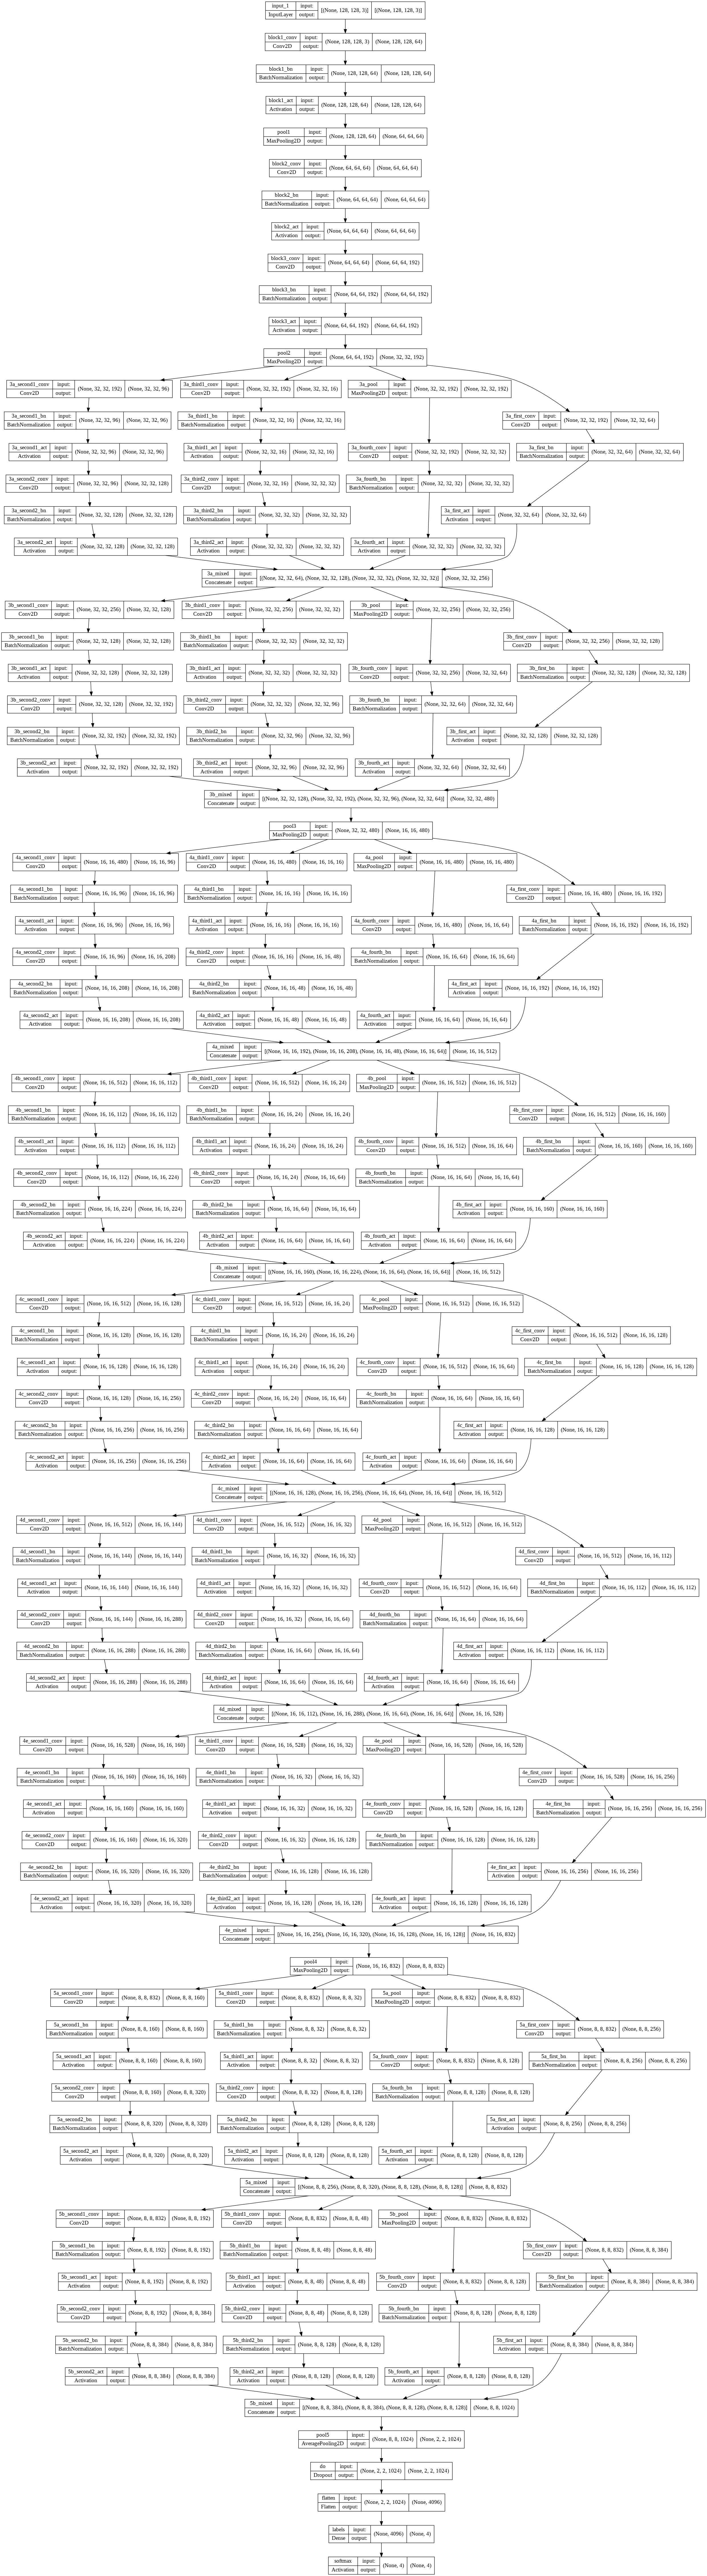

In [ ]:
from keras.utils.vis_utils import plot_model
model = GoogLeNet.build(width = 128, height = 128, depth = 3, classes =4, reg = 0.0002)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

Model: "googlenet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv (Conv2D)           (None, 128, 128, 64  4864        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_bn (BatchNormalization)  (None, 128, 128, 64  256        ['block1_conv[0][0]']            
                                )                                                         

In [ ]:
#untuk optimizer
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
print("[INFO] training network...")
opt = tf.optimizers.Adam(learning_rate = 0.0001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] training network...


In [ ]:
#set early stopping criteria
from keras.callbacks import EarlyStopping, ModelCheckpoint
#pat = 15 #this is the number of epochs with no improvment after which the training will stop
#early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

#define the model checkpoint callback -> this will keep on saving the model as a physical file
filepath="model.h5"
checkpoint = ModelCheckpoint('model5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=50, BATCH_SIZE=32):
  
    model = GoogLeNet.build(width = 128, height = 128, depth = 3, classes =4, reg = 0.0002)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    results = model.fit(t_x, t_y, validation_data=(val_x, val_y), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks_list)  
    print("Train Score: ", model.evaluate(t_x, t_y))
    print("Val Score: ", model.evaluate(val_x, val_y))
    print("Test Score: ", model.evaluate(X_test, Y_test))

    return results

In [ ]:
n_folds=5
epochs=50
batch_size=32

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(X_train, Y_train, test_size=0.2, random_state = 4)
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
print("======="*12, end="\n\n\n")


Training on Fold:  1
Epoch 1/50
29/29 [==============================] - ETA: 0s - loss: 2.6051 - accuracy: 0.5683
Epoch 1: val_accuracy improved from -inf to 0.24561, saving model to model5
INFO:tensorflow:Assets written to: model5/assets
29/29 [==============================] - 49s 1s/step - loss: 2.6051 - accuracy: 0.5683 - val_loss: 3.2196 - val_accuracy: 0.2456
Epoch 2/50
29/29 [==============================] - ETA: 0s - loss: 2.1652 - accuracy: 0.8007
Epoch 2: val_accuracy did not improve from 0.24561
29/29 [==============================] - 3s 111ms/step - loss: 2.1652 - accuracy: 0.8007 - val_loss: 4.0513 - val_accuracy: 0.2456
Epoch 3/50
29/29 [==============================] - ETA: 0s - loss: 2.0358 - accuracy: 0.8469
Epoch 3: val_accuracy did not improve from 0.24561
29/29 [==============================] - 3s 111ms/step - loss: 2.0358 - accuracy: 0.8469 - val_loss: 4.9855 - val_accuracy: 0.2456
Epoch 4/50
29/29 [==============================] - ETA: 0s - loss: 1.9892 - ac

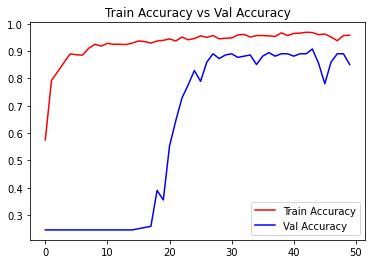

In [ ]:
import matplotlib.pyplot as plt
plt.title('Train Accuracy vs Val Accuracy')
#plt.plot(model_history[0].history['acc'], label='Train Accuracy Fold 1', color='black')
#plt.plot(model_history[0].history['val_acc'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
#plt.plot(model_history[1].history['acc'], label='Train Accuracy Fold 2', color='red', )
#plt.plot(model_history[1].history['val_acc'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
#plt.plot(model_history[2].history['acc'], label='Train Accuracy Fold 3', color='green', )
#plt.plot(model_history[2].history['val_acc'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
#plt.plot(model_history[3].history['acc'], label='Train Accuracy Fold 2', color='blue', )
#plt.plot(model_history[3].history['val_acc'], label='Val Accuracy Fold 2', color='blue', linestyle = "dashdot")
plt.plot(model_history[4].history['accuracy'], label='Train Accuracy', color='red', )
plt.plot(model_history[4].history['val_accuracy'], label='Val Accuracy', color='blue', )
plt.legend()
plt.savefig("Model5 of Accuracy_fold7.jpg")
plt.show()

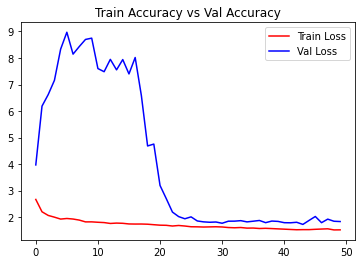

In [ ]:
plt.title('Train Accuracy vs Val Accuracy')
#plt.plot(model_history[0].history['acc'], label='Train Accuracy Fold 1', color='black')
#plt.plot(model_history[0].history['val_acc'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
#plt.plot(model_history[1].history['acc'], label='Train Accuracy Fold 2', color='red', )
#plt.plot(model_history[1].history['val_acc'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
#plt.plot(model_history[2].history['acc'], label='Train Accuracy Fold 3', color='green', )
#plt.plot(model_history[2].history['val_acc'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
#plt.plot(model_history[3].history['acc'], label='Train Accuracy Fold 2', color='blue', )
#plt.plot(model_history[3].history['val_acc'], label='Val Accuracy Fold 2', color='blue', linestyle = "dashdot")
plt.plot(model_history[4].history['loss'], label='Train Loss', color='red', )
plt.plot(model_history[4].history['val_loss'], label='Val Loss', color='blue', )
plt.legend()
plt.savefig("Model5 of Loss_fold7.jpg")
plt.show()

In [ ]:
from keras.models import load_model
modeltest = load_model('model5')

In [ ]:
predictions_test = modeltest.predict(X_test)
predictions_uji=np.argmax(predictions_test, axis=1)
y_testuji=np.argmax(Y_test, axis=1)